In [1]:
path = "FC_PRIMNET/FINGER"

from path_handler import get_BASERDIR
import os
BASEDIR, RUNMODE = get_BASERDIR(".")

if BASEDIR.absolute().name == "control":
    os.chdir("..")
os.getcwd()

Running on Jupyter...


'/home/terry/Rilab/sOftrobot/PRIMNET-V2/code'

In [2]:
# %%
from pathlib import Path
import sys

try: 
    get_ipython().__class__.__name__
    BASEDIR = Path().absolute()
except: BASEDIR = Path(__file__).parent

sys.path.append(str(BASEDIR))
import torch
from torch import nn
import argparse

import numpy as np
from utils import dataloader
from utils.initalize import INITALZE_EVEN_JOINTS
from utils.update import  update_primnet, update_fc_primnet, update_pcc_primnet


import os
import random
from pathlib import Path
import wandb
import time
import json

from utils.tools import set_seed, set_wandb, print_log_dict, prefix_dict, average_dict
from utils.path_handler import JUPYTER, RUN, DEBUG, get_BASERDIR
from utils.args import read_ARGS
from utils.logger import CSVLogger,ask_and_make_folder
from utils.tools import cast_numpy

from configs.template import PRIMNET_ARGS_TEMPLATE, FC_PRIMNET_ARGS_TEMPLATE, PCC_PRIMNET_ARGS_TEMPLATE
from model.PRIMNET import PRIMNET
from model.FC_PRIMNET import FC_PRIMNET
from typing import Union

from utils.dataloader import get_dataset, Sampler

In [3]:
BASEDIR, RUNMODE = get_BASERDIR(os.getcwd())
args = read_ARGS((BASEDIR/'results'/path/"args.py").absolute())
args

Running on Jupyter...


ARGS(MODEL='FC_PRIMNET', WANDB=True, pname='PRIMNET_v2.2', runname='FINGER', DATASET='FINGER', LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, epochs=2000, focus_ratio=0.0, data_ratio=1.0, n_workers=2, batch_size=64, marker_num=1, motor_dim=2)

In [4]:
if args.MODEL == 'PRIMNET':
    model = PRIMNET(args=args).to(args.device)
elif args.MODEL == 'FC_PRIMNET':
    model = FC_PRIMNET(args=args).to(args.device)

model.load_state_dict(torch.load(BASEDIR/'results'/path/"weights/epoch_1000.pth"))

<All keys matched successfully>

In [5]:
def forward_motor(model:PRIMNET, motor_control):     
    motor_control = model.normalize(motor_control)
    
    # Forward
    act_embeds = model.ACT_EMBED.layers(motor_control)
    q_values = model.FK_LAYER.forward_q(act_embeds)
    joint_se3 = model.FK_LAYER.forward_kinematics(q_values)
    
    return model.t2p(joint_se3, OUTPUT_NORMALIZE=False)



## Forward Kinematics

In [6]:
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/FINGER.json", args.data_ratio)

In [7]:
model.motor_mean, model.motor_std, model.position_mean, model.position_std

(tensor([-19.8229,  48.9722]),
 tensor([579.6077, 604.4758]),
 tensor([[0.],
         [0.],
         [0.]]),
 tensor([[1.],
         [1.],
         [1.]]))

/tmp/ipykernel_63035/702957621.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


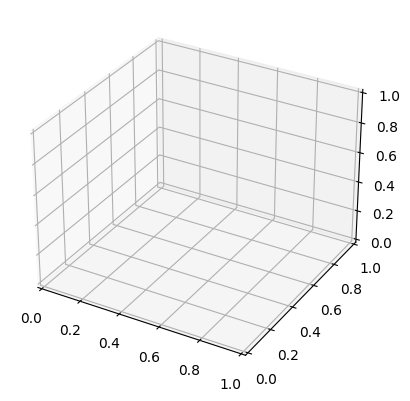

In [8]:
from matplotlib import pyplot as plt
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')

length = 3
start_point = random.randint(0, 1000)
cmap = get_cmap(len(train_dataset.position[start_point:start_point+length]))

for i, (pos,actuation) in enumerate(
    zip(train_dataset.position[start_point:start_point+length],
        train_dataset.motor_control[start_point:start_point+length])):
    
    
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0], pos_[1], pos_[2], c=cmap(i))
    
    actuation = actuation/10_000
    ax.scatter(actuation[0], actuation[1], 0, c=cmap(i))
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

plt.show()
    

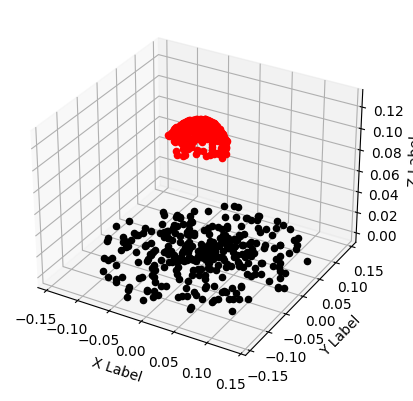

In [9]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


for pos in train_dataset.position:
    pos_ = pos[0,:,0]
    ax.scatter(pos_[0], pos_[1], pos_[2], c='r')
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    


for actuation in train_dataset.motor_control:
    actuation = actuation/10_000
    ax.scatter(actuation[0], actuation[1], 0, c='k')

plt.show()
    

In [10]:
rest_pos = model(torch.zeros(1,2).to(torch.float))[0,-1].detach().numpy()

In [11]:
idx = 4

train_dataset.motor_control[idx], train_dataset.position[idx]

(tensor([268.3167, 103.5121]),
 tensor([[[-0.0014],
          [ 0.0102],
          [ 0.1246]]]))

tensor([[ -78.5764, -147.8020]])
tensor([ 0.0059, -0.0016,  0.1252])


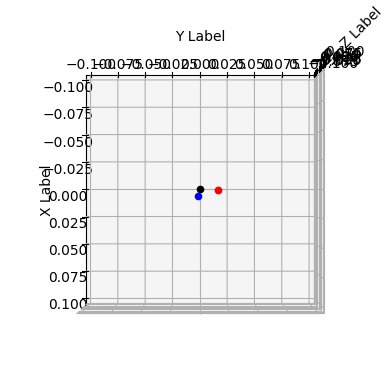

tensor([[1032.9440,  822.7830]])
tensor([-0.0249,  0.0298,  0.1105])


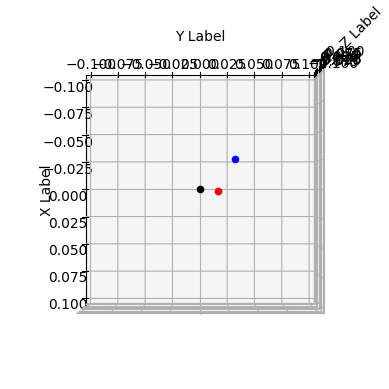

tensor([[-68.7785, 831.1788]])
tensor([-0.0325,  0.0063,  0.1182])


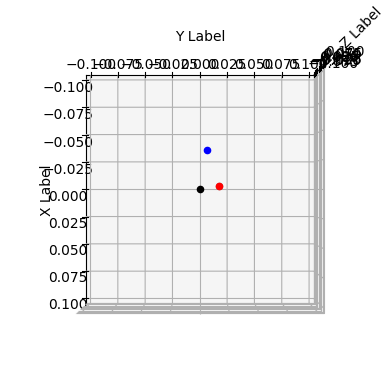

tensor([[-128.5803, -503.0440]])
tensor([ 0.0163, -0.0039,  0.1211])


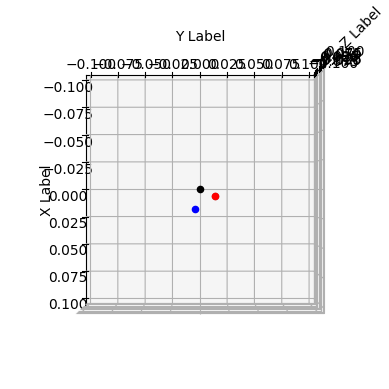

tensor([[-44.1448,  19.3841]])
tensor([0.0012, 0.0003, 0.1266])


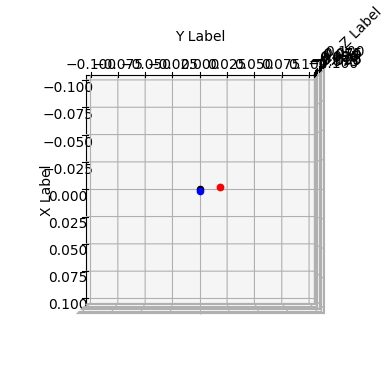

tensor([[ -204.3548, -1137.7843]])
tensor([ 0.0344, -0.0078,  0.1096])


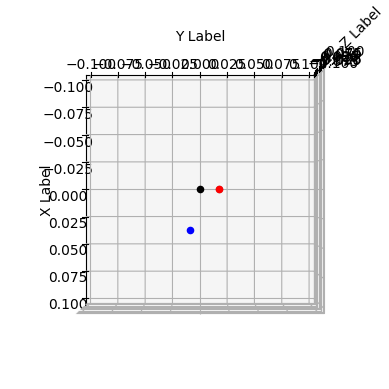

tensor([[ 691.3549, -678.2850]])
tensor([0.0194, 0.0137, 0.1149])


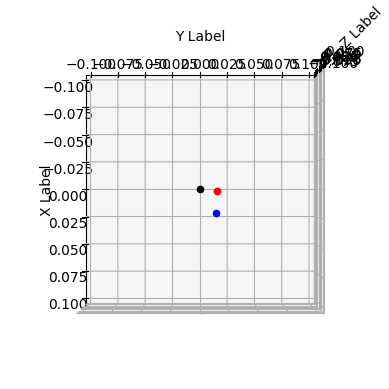

tensor([[ -9.8516, 540.7766]])
tensor([-0.0226,  0.0017,  0.1226])


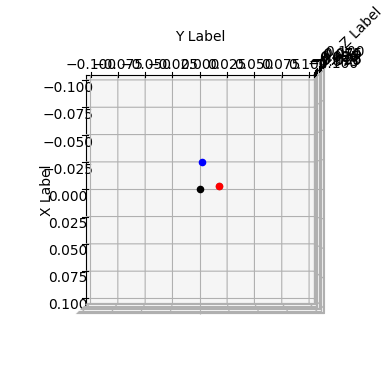

tensor([[-627.2300, -202.1546]])
tensor([ 0.0025, -0.0222,  0.1194])


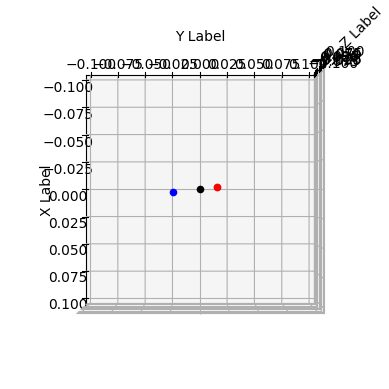

tensor([[345.5195, 549.8806]])
tensor([-0.0225,  0.0112,  0.1205])


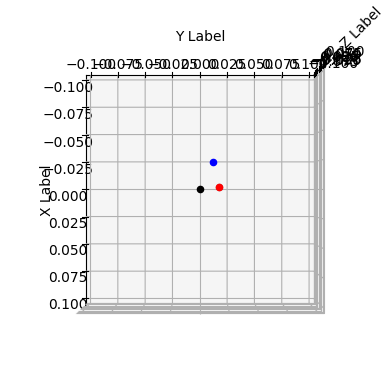

In [12]:
from matplotlib import pyplot as plt


for idx in range(10,20):

    motor_control = train_dataset.motor_control[idx][None,:]
    print(motor_control)
    target_position = train_dataset.position[idx].flatten()
    print(target_position)

    ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()
    # ps[-1,:], target_position

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    ax.scatter(0,0,0,color='k')
    i = 0
    for p in ps:
        i = i +1
        ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1 + 0.3)
    
    ax.scatter(p[0], p[1],p[2], color = 'r', alpha = 1)

    for p_fr, p_to in zip(ps[:-1], ps[1:]):
        ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

    ax.scatter(target_position[0], target_position[1], target_position[2], color='b')

    ax.set_xlim(-0.10, 0.10)
    ax.set_ylim(-0.10, 0.10)
    ax.set_zlim(-0.10, 0.10)
    
    # name x,y,z label to ax
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    
    ax.view_init(elev=90, azim=0)

    plt.show()




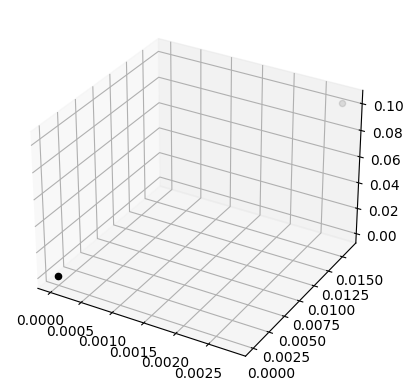

array([0.00285014, 0.01626727, 0.1023813 ], dtype=float32)

In [13]:
motor_control = torch.FloatTensor([1000,0]).unsqueeze(0)
ps = model(motor_control)[0].detach().cpu().squeeze(-1).numpy()

from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(0,0,0,color='k')

i = 0
for p in ps:
    i = i +1
    ax.scatter(p[0], p[1],p[2], color = 'k', alpha = i *0.1)

for p_fr, p_to in zip(ps[:-1], ps[1:]):
    ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]], [p_fr[2], p_to[2]], color="red")

# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.2, 0.2)
# ax.set_zlim(-0.2, 0.2)
plt.show()

# print(ps[-1,:,0])
ps[-1]

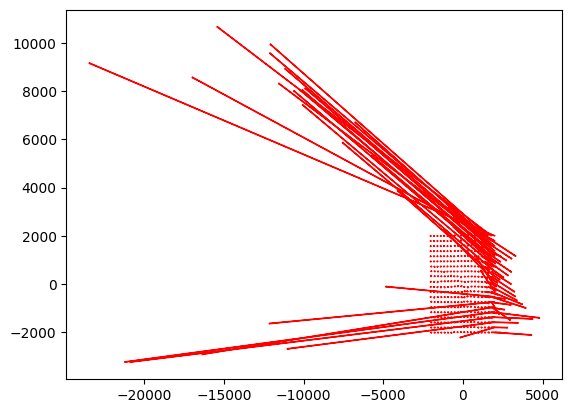

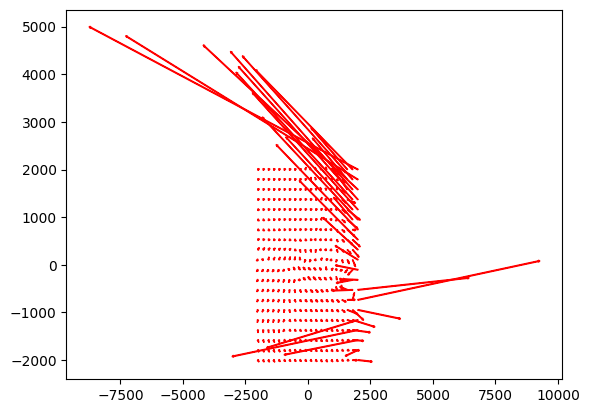

In [14]:
from jacobian import jacobian
from functools import partial

def forward_soro(soro,actuation):
    ps = soro(actuation)
    pos_EE = ps[:,-1,0:2,0]

    return pos_EE

# plot jacobian field

x = torch.linspace(-2000, 2000, 20)
y = torch.linspace(-2000, 2000, 20)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act1 = jac[0,:,0,0] * 8e5 * 2

    # plt plot arrow on position (x,y) to (x+jac_act[0], y+jac_act[1]))
    # plt.arrow(x,y, jac_act1[0], jac_act1[1], color='r', alpha=1)
    # change arrow width to 1
    plt.arrow(x,y, jac_act1[0], jac_act1[1], color='r', alpha=1, width=14)

plt.show()    

for (x,y) in zip(grid_x.flatten(), grid_y.flatten()):
    actuation = torch.FloatTensor([x,y]).reshape(1,-1)
    jac, pos_EE = jacobian(partial(forward_soro,model), actuation)
    jac_act2 = jac[0,:,0,1] * 8e5 * 2

    # plt plot arrow on position (x,y) to (x+jac_act[0], y+jac_act[1]))
    # plt.arrow(x,y, jac_act1[0], jac_act1[1], color='r', alpha=1)
    # change arrow width to 1
    plt.arrow(x,y, jac_act2[0], jac_act2[1], color='r', alpha=1, width=14)

plt.show()

In [86]:
ps

array([[-7.1443394e-03,  7.9865847e-03,  1.6545908e-01],
       [ 3.1398039e-02,  2.1940576e-02,  5.1674330e-01],
       [-3.1695215e-03,  1.3343653e-01,  7.1550751e-01],
       [-5.1986098e-02,  1.6439570e-01,  1.1571853e+00],
       [ 1.7062823e+00, -1.6891748e+00, -5.6716204e-01],
       [-2.6165463e-02, -2.2959933e-02, -2.3889662e-01],
       [ 3.8526766e-04,  2.9498046e-02,  1.1770280e-01]], dtype=float32)